마스크 착용여부를 확인하는 모델을 만들어봅시다

https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data_dir = '/content/drive/MyDrive/Tensorflow AI/New Masks Dataset'
img_height = 150
img_width = 150

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Train',    
  image_size=(img_height, img_width))

Found 600 files belonging to 2 classes.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Validation',    
  image_size=(img_height, img_width))

Found 306 files belonging to 2 classes.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir+'/Test',    
  image_size=(img_height, img_width))

Found 100 files belonging to 2 classes.


pretrained model을 불러와봅시다

https://www.tensorflow.org/api_docs/python/tf/keras/applications

이때 include_top=False로 하여 특징 추출 부분만 가져옵니다

In [6]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights = 'imagenet',include_top=False, input_shape=(150,150,3))

In [7]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

Top이 포함되지 않은 최종 결과 값을 확인해봅시다

In [8]:
vgg_res = vgg_model.predict(train_ds)

In [9]:
type(vgg_res)

numpy.ndarray

In [10]:
vgg_res.shape

(600, 4, 4, 512)

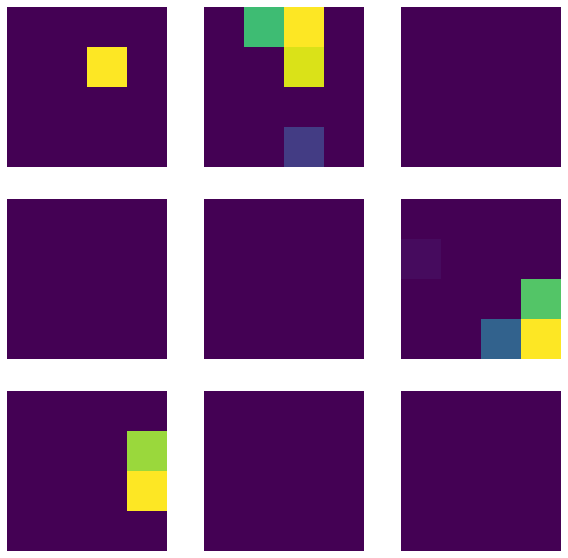

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(vgg_res[0,:,:,i])
    
    plt.axis("off")

새로운 라벨을 분류할 수 있도록 Fully Connected Layer를 새로 만듭니다. 

이때 기존 VGG 모델 부분은 weight가 바뀌지 않게 하고
FC 레이어만 트레이닝 합니다

이렇게 하면 VGG의 특징 추출을 활용하여 새로운 라벨을 분류하는 부분만 학습하기 때문에 쉽게 학습 가능합니다. 

In [12]:
vgg_model.trainable = False

In [13]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
from tensorflow.keras import Sequential, Model, layers
transfer_model = Sequential()

In [15]:
transfer_model.add(vgg_model)

In [16]:
transfer_model.add(layers.Flatten())
transfer_model.add(layers.Dense(256,activation='relu'))
transfer_model.add(layers.Dropout(0.5))
transfer_model.add(layers.Dense(2,activation='softmax'))

transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16,812,610
Trainable params: 2,097,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
transfer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = transfer_model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
19/19 [==============================] - 205s 11s/step - loss: 5.1611 - acc: 0.8950 - val_loss: 1.3131 - val_acc: 0.9771
Epoch 2/10
19/19 [==============================] - 204s 11s/step - loss: 0.5701 - acc: 0.9833 - val_loss: 2.6886 - val_acc: 0.9673
Epoch 3/10
19/19 [==============================] - 205s 11s/step - loss: 2.0971 - acc: 0.9733 - val_loss: 4.6546 - val_acc: 0.9281
Epoch 4/10
19/19 [==============================] - 207s 11s/step - loss: 0.2338 - acc: 0.9967 - val_loss: 1.7398 - val_acc: 0.9771
Epoch 5/10
19/19 [==============================] - 207s 11s/step - loss: 0.2073 - acc: 0.9950 - val_loss: 1.2997 - val_acc: 0.9837
Epoch 6/10
19/19 [==============================] - 206s 11s/step - loss: 0.0470 - acc: 0.9983 - val_loss: 1.2778 - val_acc: 0.9771
Epoch 7/10
19/19 [==============================] - 205s 11s/step - loss: 0.0848 - acc: 0.9967 - val_loss: 2.0916 - val_acc: 0.9706
Epoch 8/10
19/19 [==============================] - 204s 11s/step - loss: 0.

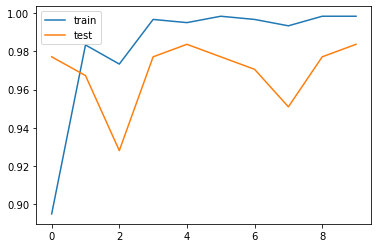

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train', 'test'], loc='upper left')

In [20]:
# 테스트셋 정확도 평가

test_loss , test_acc = transfer_model.evaluate(test_ds)
print('test acc :{} test loss:{}'.format(test_acc,test_loss))

4/4 [==============================] - 42s 5s/step - loss: 0.2737 - acc: 0.9900
test acc :0.9900000095367432 test loss:0.27367180585861206


In [21]:
# 모델 저장하기
transfer_model.save(data_dir+'mask_tl.h5')